In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import argparse
import re 
import json
import numpy as np
from transformers import CamembertTokenizerFast

from kmembert.preprocesser import EHRPreprocesser
from kmembert.utils import print_args, get_label
from kmembert.preprocessing.extract_unknown_words import in_camembert_voc

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def strDate_to_days(row, date_format = "%Y-%m-%d"):
    '''
        When there's no FLAG_DECES column in the df
    '''
    a = datetime.strptime(row['Date deces'], date_format)
    b = datetime.strptime(row['Date cr'], date_format)
    val = (a-b).days
    return val

def changeFormat(df: pd.DataFrame, flag_GR: bool):
    if(flag_GR):
        df = df[0].str.split(',', expand=True)
        df = df.iloc[1:,[0,2,3]]
        df.columns = ["Noigr", "Date deces", "Date cr"]

    df['Date cr'] = df['Date cr'].apply(lambda x: str(x) )
    df['Date cr'] = df['Date cr'].apply(lambda x: '-'.join([x[:4], x[4:6], x[6:]]))
    df['Date deces'] = df['Date deces'].apply(lambda x: str(x) )
    df['Date deces'] = df['Date deces'].apply(lambda x: '-'.join([x[:4], x[4:6], x[6:]]))
    df['survival_time'] = df.apply(strDate_to_days, axis=1)

    return df

In [6]:
# Lecture des données
# Compter le nombre de documents par patients
import pandas as pd 

result = pd.read_csv("doc_toTest\\test_rs0.csv")
result = changeFormat(result, False)

for i in range(1, 10):
    # Read the data
    file_name = "doc_toTest\\test_rs"+str(i)+".csv"
    df_read = pd.read_csv(file_name)
    df_read = changeFormat(df_read, False)
    # Concatenate to have all rows
    frames = [result, df_read]
    result = pd.concat(frames)

result = result.drop_duplicates()

In [7]:
# Fonction count_sentence qui compte le nombre de sentence
def count_sentence(x, tokenizer, preprocesser, voc):
    count_token = 0

    x["Texte"] = preprocesser(x["Texte"])

    known_tokens = 0
    for word in re.findall(r'\w+', x["Texte"]):
        word = word.lower()
        if in_camembert_voc(word, voc):
            known_tokens += 1

    nb_tokens = len(tokenizer(x["Texte"], max_length=2000)["input_ids"])
    splitted_by_sentence = re.split(r'[.!?]+', str(x["Texte"]))
    total_sentence = len(splitted_by_sentence) - 1
    for s in splitted_by_sentence :
        if len(s): count_token += (len(tokenizer(s)["input_ids"]) - 1)

    mean_tokens = count_token / max(1, total_sentence)
    return pd.Series([total_sentence, mean_tokens, nb_tokens, known_tokens], index = ["total_sentence", "mean_tokens", "nb_tokens", "known_tokens"])

In [17]:
# Import tokenizer, preprocessor et voc
tokenizer = CamembertTokenizerFast.from_pretrained("camembert-base")
preprocessor = EHRPreprocesser()
voc = set(tokenizer.get_vocab().keys())

In [36]:
df_count = result.apply(lambda x : count_sentence(x, tokenizer, preprocessor, voc), axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (1039 > 512). Running this sequence through the model will result in indexing errors


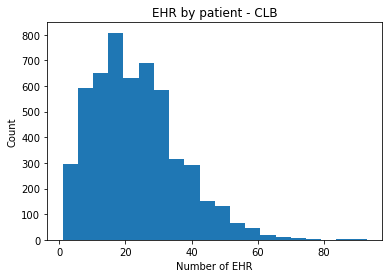

In [40]:
# EHR by patient
plt.figure(1)
ehr_by_id = result["Noigr"].value_counts()
ehr_by_id.plot.hist(bins=20)
plt.title("EHR by patient - CLB")
plt.xlabel("Number of EHR")
plt.ylabel("Count")
plt.savefig("ehr_distribution.png")

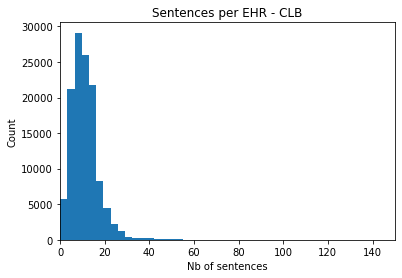

In [41]:
total_sentence_max = df_count["total_sentence"].max()
max_value_desired = 150
plt.figure(2)
plt.xlim((0, min(total_sentence_max, max_value_desired)))
df_count["total_sentence"].plot.hist(bins=50)
plt.title("Sentences per EHR - CLB")
plt.xlabel("Nb of sentences")
plt.ylabel("Count")
plt.savefig("sentences_distribution.png")

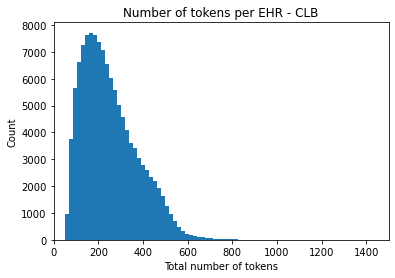

In [42]:
# Number of tokens per EHR
plt.figure()
max_tokens = df_count["nb_tokens"].max()
nb_tokens_desired = 1500 
plt.xlim((0, min(max_tokens, nb_tokens_desired)))
df_count["nb_tokens"].plot.hist(bins=100)
plt.title("Number of tokens per EHR - CLB")
plt.xlabel("Total number of tokens")
plt.ylabel("Count")
plt.savefig("nb_tokens_distribution.png")

In [26]:
# Fonction count_sentence qui compte le nombre de sentence
def count_sentence_mean_word(x, tokenizer, preprocesser, voc):
    count_token = 0

    x["Texte"] = preprocesser(x["Texte"])

    known_tokens = 0
    for word in re.findall(r'\w+', x["Texte"]):
        known_tokens += 1
    splitted_by_sentence = re.split(r'[.!?]+', str(x["Texte"]))
    total_sentence = len(splitted_by_sentence)
    
    mean_word_sequence = known_tokens/total_sentence

    mean_tokens = count_token / max(1, total_sentence)
    return pd.Series([mean_word_sequence], index = ["mean_tokens"])

In [43]:
df_count = result.apply(lambda x : count_sentence_mean_word(x, tokenizer, preprocessor, voc), axis=1)

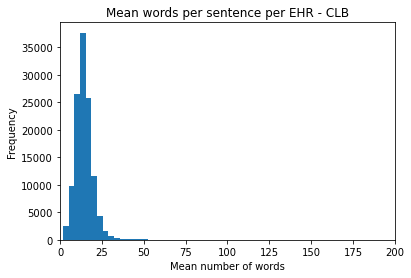

In [44]:
# Mean Words Per Sentence per EHR
plt.figure()
max_mean_tokens = df_count["mean_tokens"].max()
max_mean_tokens_desired = 200 
plt.xlim((0, min(max_mean_tokens, max_mean_tokens_desired)))
df_count["mean_tokens"].plot.hist(bins=100)
plt.title("Mean words per sentence per EHR - CLB")
plt.xlabel("Mean number of words")
plt.savefig("mean_words_distribution.png")